# Null-text inversion for stable preferences
The goal of this notebook is to be able to run the null-text inversion code and then experiment ways to use it for incorporating users' preferences in the generation process.

In [6]:
# pick a GPU
! export CUDA_VISIBLE_DEVICES=2

In [7]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import ptp_utils
import numpy as np
from PIL import Image
from typing import Optional, Union, List, Tuple
from tqdm import tqdm
from torch.optim.adam import Adam
import torch.nn.functional as nnf
from diffusers import UNet2DConditionModel
import seq_aligner


model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda:7"

In [8]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler = scheduler)
pipe = pipe.to(device)

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 75658.25it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Run this cell only to check whether the stable diffusion pipeline is working

100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


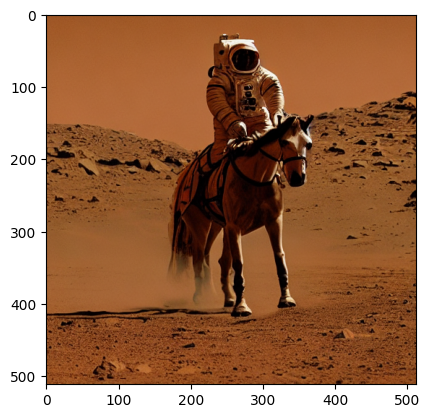

In [11]:
import matplotlib.pyplot as plt
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]  
    
plt.imshow(image)

Disable memory efficient attention

In [12]:
pipe.disable_xformers_memory_efficient_attention()

Some configurations

In [13]:
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77


In [14]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

In [15]:
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)

In [16]:
class NullInversion:
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None
        
    @property
    def scheduler(self):
        return self.model.scheduler
        
    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt
        
    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents
    
    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            #print(type(image))
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = unet(latents, t, encoder_hidden_states=context).sample
        return noise_pred
    
    def pos_optimization(self, latents, num_inner_steps, epsilon):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        cond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        for i in range(NUM_DDIM_STEPS): # optimize one time step at a time
            # uncond_embeddings = uncond_embeddings.clone().detach() # ALSO HERE WE SHOULD DETACH THE COND
            # uncond_embeddings.requires_grad = False # NOT NECESSARY
            cond_embeddings = cond_embeddings.clone().detach()
            cond_embeddings.requires_grad = True
            # optimizer = Adam([uncond_embeddings], lr=1e-2 * (1. - i / 100.))  # I THINK IT HAS TO BE COND EMBEDDINGS
            optimizer = Adam([cond_embeddings],lr=1e-2*(1.-i/100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings) # ALSO HERE, THIS SHOULD BE UNCOND, LATENT_CUR
            for j in range(num_inner_steps):
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur) # this gets the previous latent, which is the essming reconstruction of the current one
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            cond_embeddings_list.append(cond_embeddings[:1].detach())
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                latent_cur = self.get_noise_pred(latent_cur, t, False, context)
        bar.close()
        return cond_embeddings_list
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent
    
    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents
        
    def invert(self, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_512(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.pos_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings
    

In [17]:
null_inversion = NullInversion(pipe)

In [18]:
image_path = "./example_images/gnochi_mirror.jpeg"
prompt = "a cat sitting next to a mirror"

In [19]:
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)

DDIM inversion...
Null-text optimization...


100%|██████████| 500/500 [01:36<00:00,  5.18it/s]


To reset GPU memory usage

In [ ]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

# Run diffusion

In [20]:
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)

In [21]:
import abc

        
class EmptyControl:
    
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn

class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class SpatialReplace(EmptyControl):
    
    def step_callback(self, x_t):
        if self.cur_step < self.stop_inject:
            b = x_t.shape[0]
            x_t = x_t[:1].expand(b, *x_t.shape[1:])
        return x_t

    def __init__(self, stop_inject: float):
        super(SpatialReplace, self).__init__()
        self.stop_inject = int((1 - stop_inject) * NUM_DDIM_STEPS)
        

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


In [22]:
def diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False):
    if low_resource:
        noise_pred_uncond = unet(latents, t, encoder_hidden_states=context[0]).sample
        noise_prediction_text = unet(latents, t, encoder_hidden_states=context[1]).sample
    else:
        latents_input = torch.cat([latents] * 2)
        noise_pred = unet(latents_input, t, encoder_hidden_states=context).sample
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    latents = model.scheduler.step(noise_pred, t, latents)["prev_sample"]
    latents = controller.step_callback(latents)
    return latents

In [23]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    pos_embedding,
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = 1
    ptp_utils.register_attention_control(model, controller)
    height = width = 512
    
    text_embeddings = pos_embedding 
    uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", return_tensors="pt"
        )
    uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    
    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        context = torch.cat([uncond_embeddings_, text_embeddings[i]])
        latents = diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = ptp_utils.latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent


In [24]:
prompts = [prompt]
pos_embeddings = uncond_embeddings
controller = AttentionStore()
pipe.to(device)
images, x_t = text2image_ldm_stable(pipe, pos_embeddings, controller, latent=x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=None)


100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


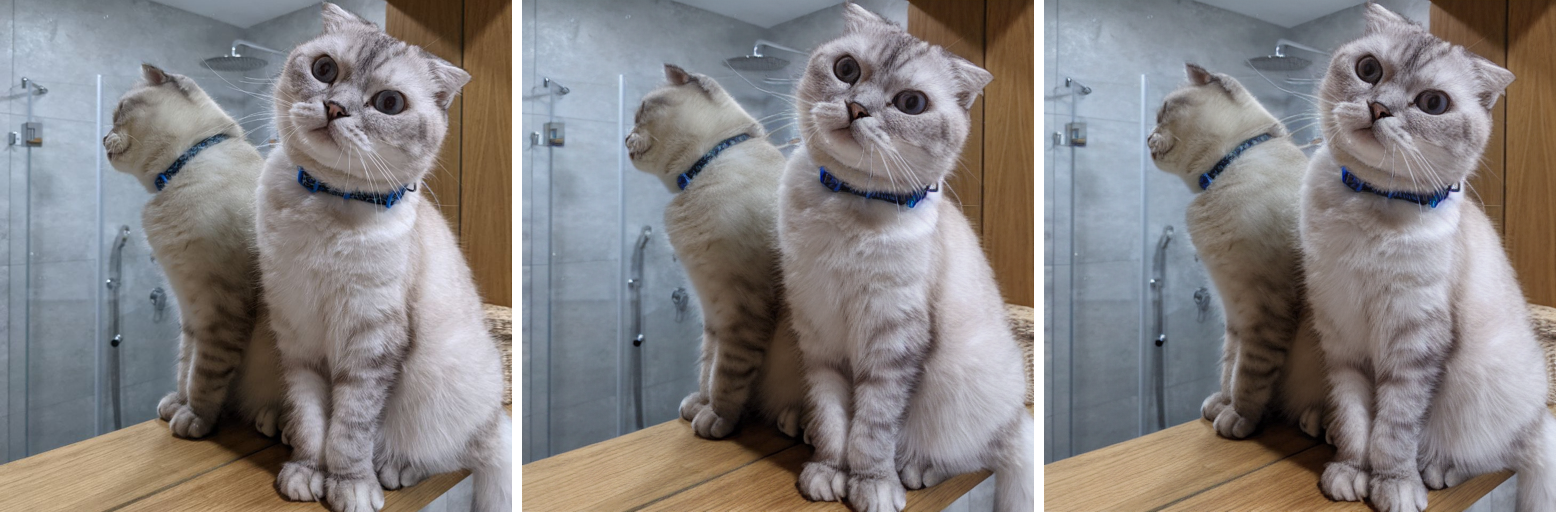

In [25]:
ptp_utils.view_images([image_gt, image_enc, images[0]])

Ok now let's try with other images

In [26]:
def get_embeddings_one_image(image_path, prompt, show=True, save_path=None):
    (image_gt, image_enc), x_t, pos_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)
    prompts = [prompt]
    controller = AttentionStore()
    pipe.to(device)
    images, x_t = text2image_ldm_stable(pipe, pos_embeddings, controller, latent=x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=None)
    ptp_utils.view_images([image_gt, image_enc, images[0]])
    if save_path != None:
        emb_np = np.zeros((len(uncond_embeddings), pos_embeddings[0].shape[0],pos_embeddings[0].shape[1], pos_embeddings[0].shape[2]))
        for i in range(len(pos_embeddings)):
            emb_np[i] = pos_embeddings[i].cpu().numpy()
        np.save(save_path, emb_np)

In [36]:
img_path = './example_images/'
image_names = ['332289515_150421581246452_2041194565746961469_n',
               '332916145_759660628640622_2293614274236745754_n',
               '333319087_582419417276852_110246782087310769_n',
               '333573395_746205383847858_1035458537927676333_n',
               '334277347_6657072277639697_244111816979508053_n'
]
captions = ['a building',
            'an industrial building',
            'a library',
            'a living room',
            'a room with a bed in the back and a library in the front, partially occluding the bed']

DDIM inversion...
Null-text optimization...


100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


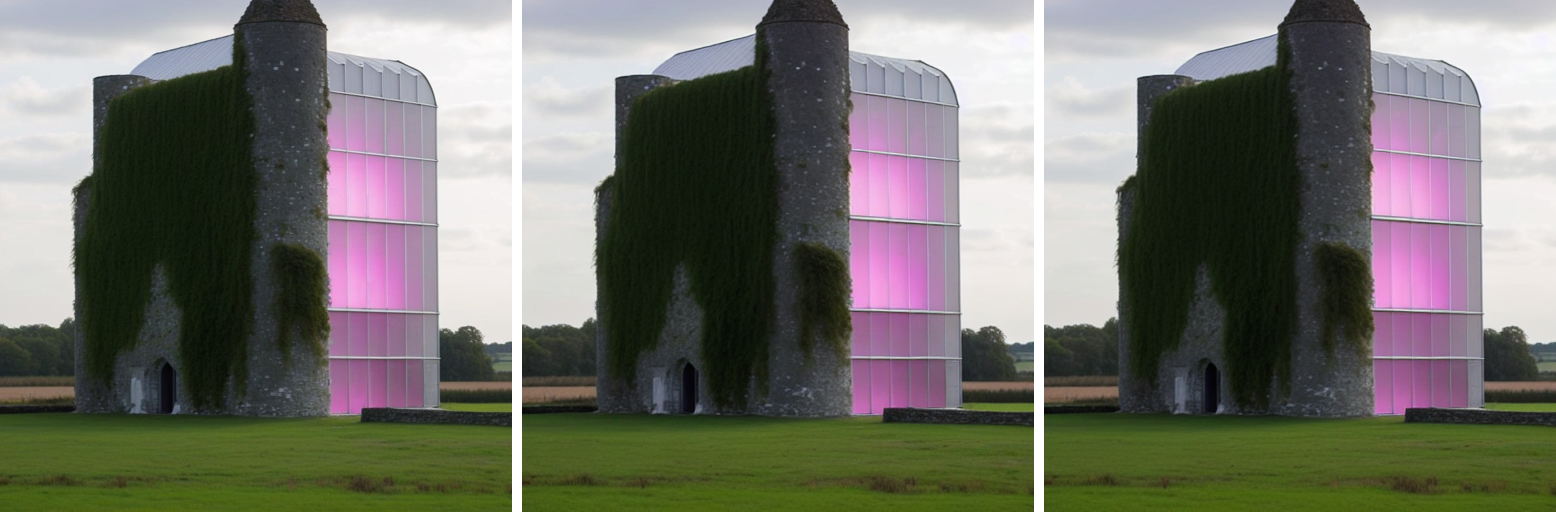

In [37]:
i = 0
path = img_path + image_names[i] +'.jpg'
save = img_path + image_names[i] +'.npy'
get_embeddings_one_image(path, captions[i], save_path=save)

DDIM inversion...
Null-text optimization...


100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


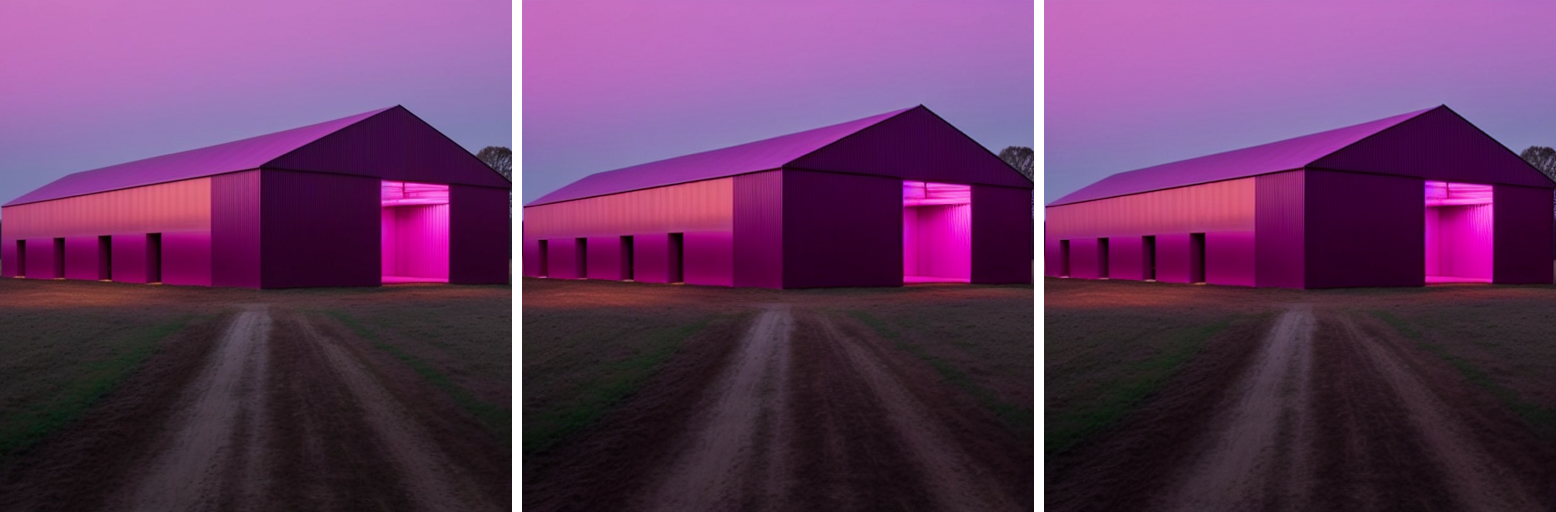

In [38]:
i +=1
path = img_path + image_names[i] +'.jpg'
save = img_path + image_names[i] +'.npy'
get_embeddings_one_image(path, captions[i], save_path=save)

DDIM inversion...
Null-text optimization...


100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


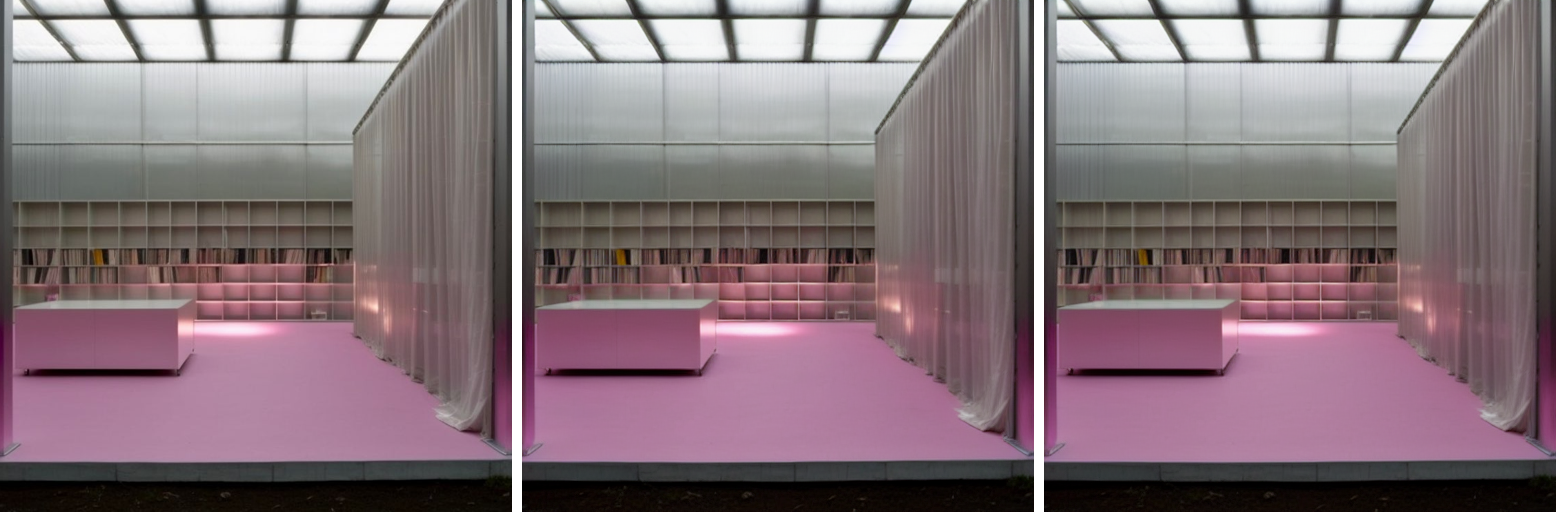

In [39]:
i +=1
path = img_path + image_names[i] +'.jpg'
save = img_path + image_names[i] +'.npy'
get_embeddings_one_image(path, captions[i], save_path=save)

DDIM inversion...
Null-text optimization...


100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


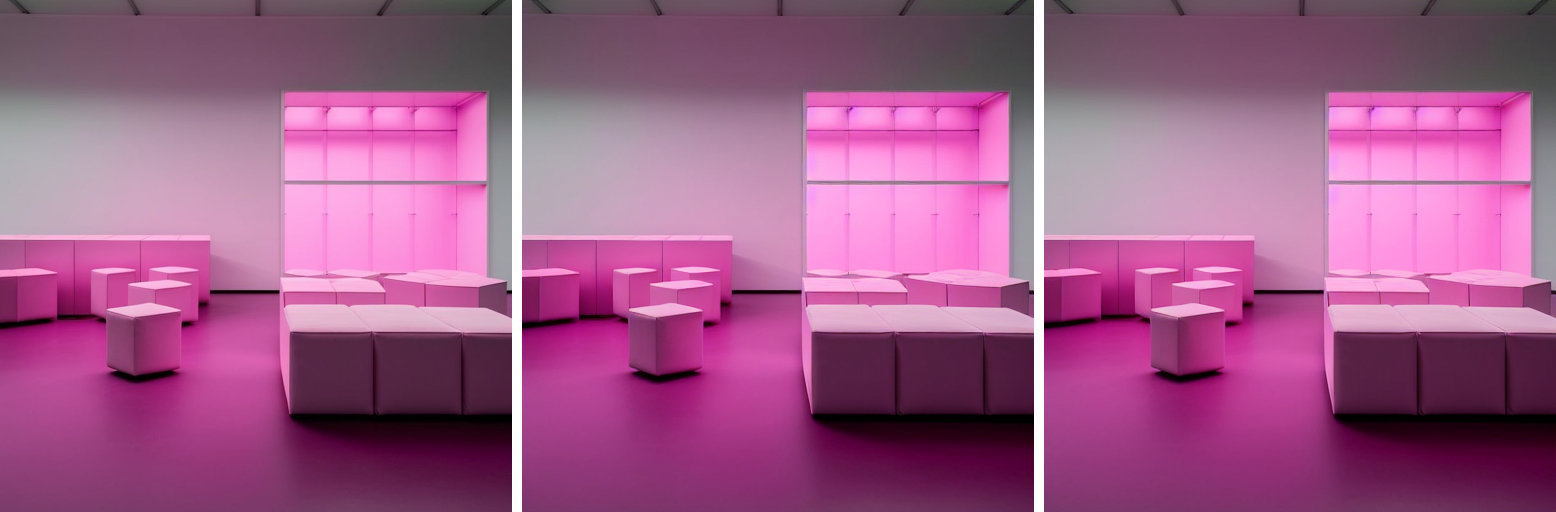

In [40]:
i +=1
path = img_path + image_names[i] +'.jpg'
save = img_path + image_names[i] +'.npy'
get_embeddings_one_image(path, captions[i], save_path=save)

DDIM inversion...
Null-text optimization...


100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


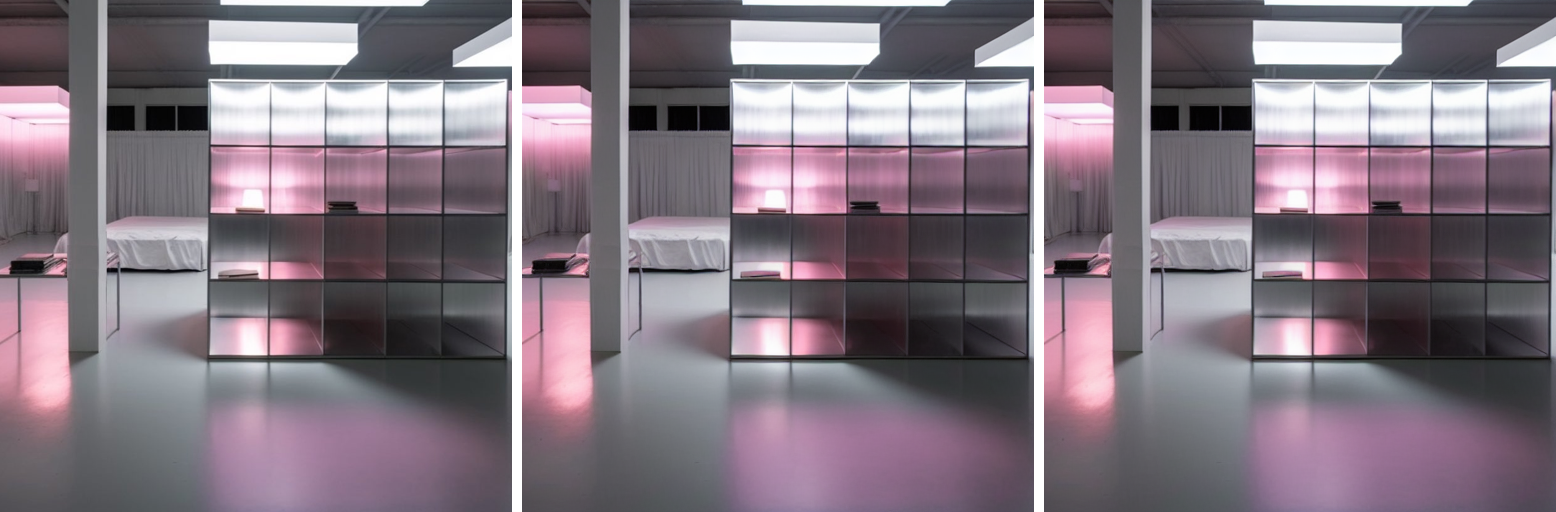

In [41]:
i +=1
path = img_path + image_names[i] +'.jpg'
save = img_path + image_names[i] +'.npy'
get_embeddings_one_image(path, captions[i], save_path=save)

# Try changing the initial noise

<class 'numpy.ndarray'>


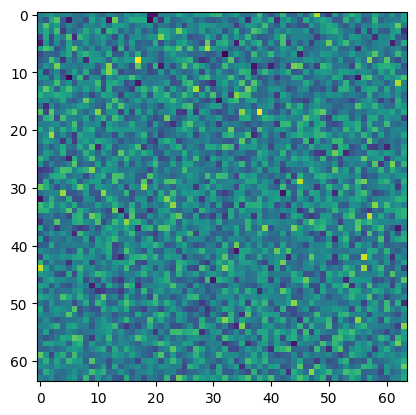

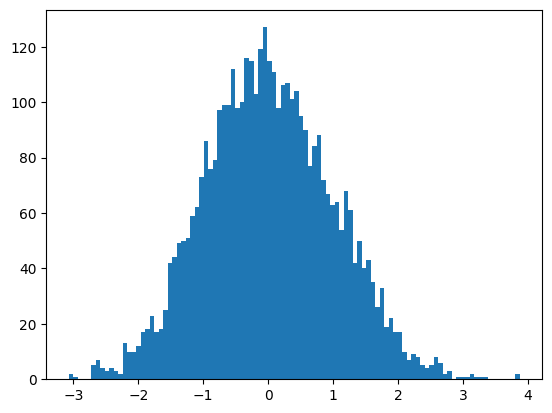

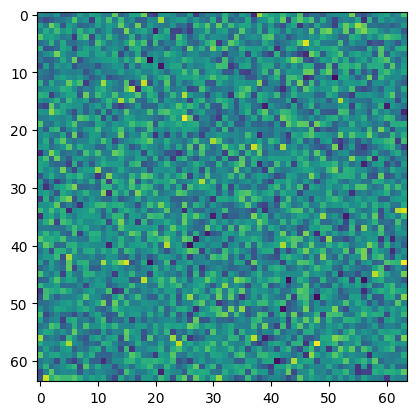

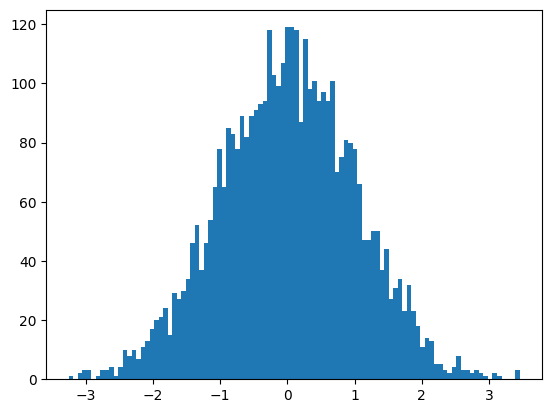

In [56]:
# visualize x_t by showing a plot
x_t_np = x_t.cpu().numpy()[0][0]
print(type(x_t_np))
plt.imshow(x_t_np)
plt.show()
# visualize a histogram of all values in x_t 
plt.hist(x_t_np.flatten(), bins=100)
plt.show()

random_new_x_t = torch.randn_like(x_t)
random_new_x_t_np = random_new_x_t.cpu().numpy()[0][0]
plt.imshow(random_new_x_t_np)
plt.show()
plt.hist(random_new_x_t_np.flatten(), bins=100)
plt.show()

In [57]:
images_r, x_t_r = text2image_ldm_stable(pipe, pos_embeddings, controller, latent=random_new_x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=None)

100%|██████████| 50/50 [00:08<00:00,  6.18it/s]


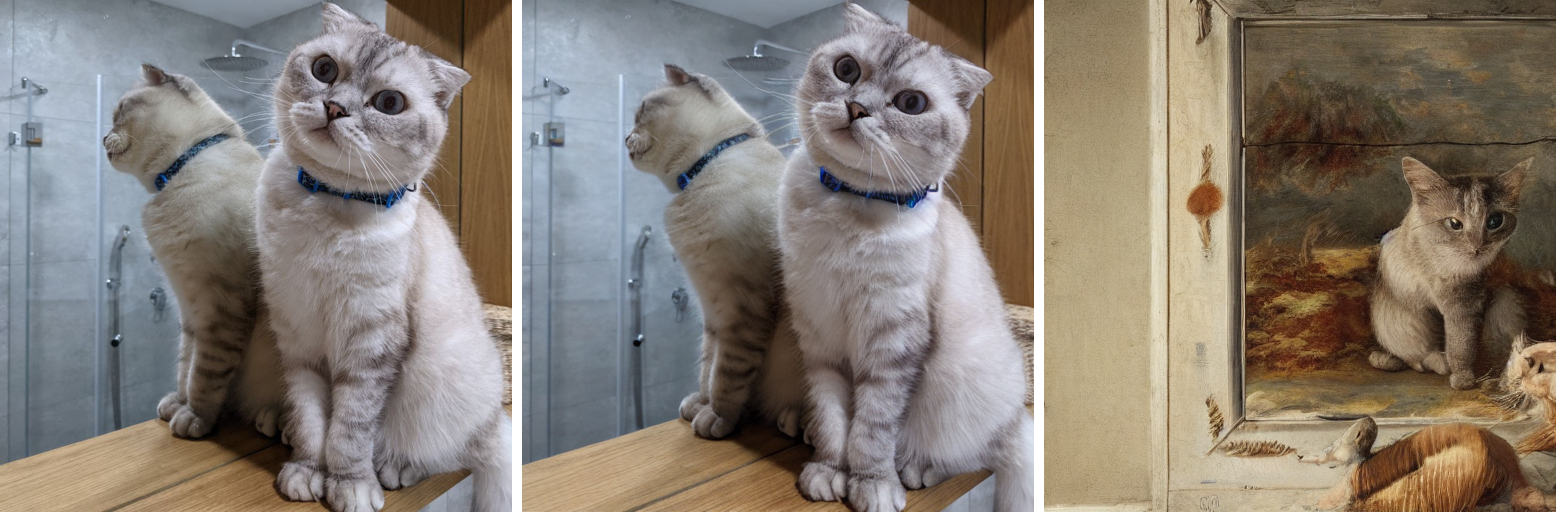

In [58]:
ptp_utils.view_images([image_gt, image_enc, images_r[0]])

Seems like a random noise doesn't really capture a very similar image. Therefore we try to finetune the embedding to be more reliable.